In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os, sys
path = os.getcwd()
while not path.endswith('research'):    
    path = os.path.abspath(os.path.join(path, '../'))
sys.path.append(path)

***

In [3]:
import sys
sys.path.append(r'C:\git\smartdata')

import smartdata
from smartdata.utils.common import print_attributes as pa
from smartdata.utils.dframe import display_full_df as ddff
from smartdata.utils.common import to_namedtuple
from smartdata.utils.file import read_from_json, create_file_name
from smartdata import SmartData

In [4]:
import logging
mpl_logger = logging.getLogger('matplotlib')
mpl_logger.setLevel(logging.WARNING)

In [5]:
from datetime import datetime, date
import pandas as pd
import json
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
import time

In [6]:
from gmt.fom.gas.shared.utils.common import *
from gmt.fom.gas.shared.utils.dframe import *

In [7]:
from gmt.fom.gas.shared.models.stpb.stpb import ShortTermPowerBurnModel
from gmt.fom.gas.shared.models.stpb.data.mongo import MongoAdapter

In [8]:
figsize=(8*1.6, 8)

# Data

In [11]:
path = r'\\trading1\Common\gasmodels\short_term_power_burn\data\UK\dependent_var\point_connect_two_weeks_ahead_forecasts.csv'

In [12]:
df = pd.read_csv(path, header=None)

In [13]:
df.head()

0                        1                        2        3  \
0  103234271  2015-07-29 13:23:00.000  2015-07-31 00:00:00.000  21678.0   
1  103234271  2015-07-29 13:23:00.000  2015-08-01 00:00:00.000  20944.0   
2  103234271  2015-07-29 13:23:00.000  2015-08-02 00:00:00.000  20987.0   
3  103234271  2015-07-29 13:23:00.000  2015-08-03 00:00:00.000  21994.0   
4  103234271  2015-07-29 13:23:00.000  2015-08-04 00:00:00.000  22365.0   

                         4  
0  2015-07-29 00:00:00.000  
1  2015-07-29 00:00:00.000  
2  2015-07-29 00:00:00.000  
3  2015-07-29 00:00:00.000  
4  2015-07-29 00:00:00.000

In [14]:
df.columns = ['curve_id','forecast_date', 'value_date', 'value',  'forecast_date2']

In [15]:
df.head()

curve_id            forecast_date               value_date    value  \
0  103234271  2015-07-29 13:23:00.000  2015-07-31 00:00:00.000  21678.0   
1  103234271  2015-07-29 13:23:00.000  2015-08-01 00:00:00.000  20944.0   
2  103234271  2015-07-29 13:23:00.000  2015-08-02 00:00:00.000  20987.0   
3  103234271  2015-07-29 13:23:00.000  2015-08-03 00:00:00.000  21994.0   
4  103234271  2015-07-29 13:23:00.000  2015-08-04 00:00:00.000  22365.0   

            forecast_date2  
0  2015-07-29 00:00:00.000  
1  2015-07-29 00:00:00.000  
2  2015-07-29 00:00:00.000  
3  2015-07-29 00:00:00.000  
4  2015-07-29 00:00:00.000

In [16]:
df = to_pd_todatetime(df, ['value_date', 'forecast_date', 'forecast_date2'])

In [17]:
t_1900  = pd.to_datetime(date(1900, 1,1))
mask = df['forecast_date'] == t_1900
df = df[~mask]

In [18]:
df = df.rename(columns={'forecast_date': 'effective_date_with_time', 
                        'forecast_date2': 'effective_date',
                        'value_date': 'point_date'})

In [19]:
df.set_index(['curve_id', 'effective_date', 'point_date' ]).sort_index(level=0).head(10)

effective_date_with_time    value
curve_id  effective_date point_date                                  
103234271 2015-07-29     2015-07-31      2015-07-29 13:23:00  21678.0
                         2015-07-31      2015-07-29 13:34:00  21678.0
                         2015-08-01      2015-07-29 13:23:00  20944.0
                         2015-08-01      2015-07-29 13:34:00  20944.0
                         2015-08-02      2015-07-29 13:23:00  20987.0
                         2015-08-02      2015-07-29 13:34:00  20987.0
                         2015-08-03      2015-07-29 13:23:00  21994.0
                         2015-08-03      2015-07-29 13:34:00  21994.0
                         2015-08-04      2015-07-29 13:23:00  22365.0
                         2015-08-04      2015-07-29 13:34:00  22365.0

## Putting into Mongo

In [9]:
myData = MongoAdapter()

2021-04-21 12:43:18,739: c:\git\gmt-fom-gas-research\gmt\fom\gas\shared\data_sources\mongo.py: 25: DEBUG: Connected successfully.


In [21]:
myData.mongo.choose_db(myData.GAS_MODELS_DB)

In [22]:
collection = myData.STPB_POINT_CONNECT_HIST_FCST
if collection not in myData.mongo.db.list_collection_names():
    myData.mongo.db.create_collection(name=collection)
    myData.mongo.choose_collection(collection)
else:
    myData.mongo.choose_collection(collection)
    myData.mongo.clear_collection()

In [23]:
time.sleep(8) #<---we need time to clean MongoDB collections

myData.mongo.pandas_to_mongo(df)

2021-04-20 13:42:05,974: c:\git\gmt-fom-gas-research\gmt\fom\gas\shared\data_sources\mongo.py: 100: DEBUG: Saving 174347 rows to MongoDb.


## Retrieving from Mongo

In [10]:
myData = MongoAdapter()

df = myData.load_stpb_historical_forecasts(); df.head()

2021-04-21 12:43:20,662: c:\git\gmt-fom-gas-research\gmt\fom\gas\shared\data_sources\mongo.py: 25: DEBUG: Connected successfully.
2021-04-21 12:43:20,761: c:\git\gmt-fom-gas-research\gmt\fom\gas\shared\models\stpb\stpb.py: 48: INFO: Retrieving....


effective_date_with_time    value
curve_id  effective_date point_date                                  
103234271 2015-07-29     2015-07-31      2015-07-29 13:23:00  21678.0
                         2015-07-31      2015-07-29 13:34:00  21678.0
                         2015-08-01      2015-07-29 13:23:00  20944.0
                         2015-08-01      2015-07-29 13:34:00  20944.0
                         2015-08-02      2015-07-29 13:23:00  20987.0

In [11]:
curves = sorted(df.index.get_level_values(0).unique().tolist());
print(curves)
print(f'\nThere are {len(curves)} curves')

[103234271, 103234272, 103234276, 103234278, 103234281, 103244609, 103244610, 103244614, 103244616, 114347004, 114349216]

There are 11 curves


In [12]:
df.head()

effective_date_with_time    value
curve_id  effective_date point_date                                  
103234271 2015-07-29     2015-07-31      2015-07-29 13:23:00  21678.0
                         2015-07-31      2015-07-29 13:34:00  21678.0
                         2015-08-01      2015-07-29 13:23:00  20944.0
                         2015-08-01      2015-07-29 13:34:00  20944.0
                         2015-08-02      2015-07-29 13:23:00  20987.0

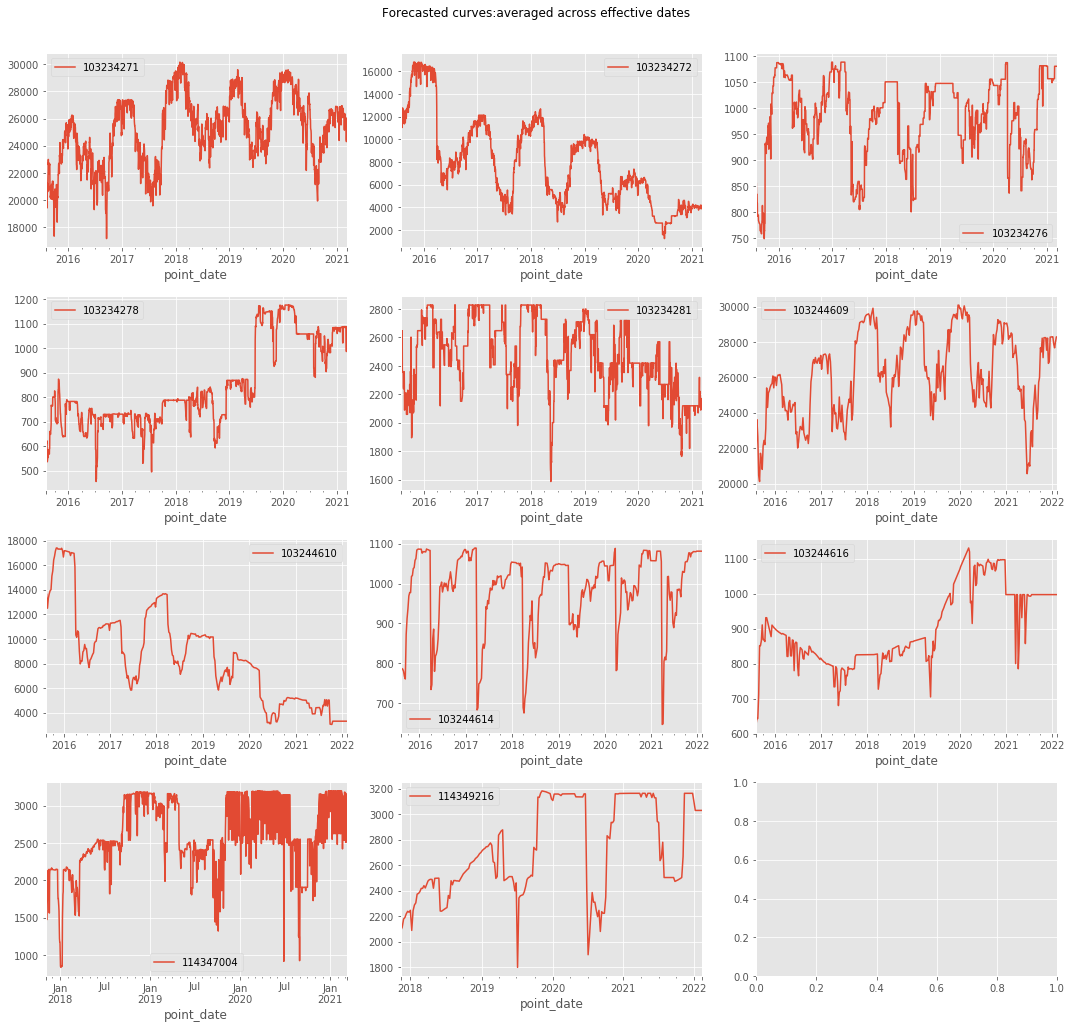

In [27]:
myData.plot_historical_forecasts(df)